# Assignment Week 1 - Group 5

### Noelani Roy, Yihong Qiu, Cosimo Cambi, Craig Perkins

In [1]:
import pandas as pd
import numpy as np

In [2]:
# main libraries
import pandas as pd
import numpy as np
from datetime import date
import geopy.distance
from math import sin, cos, sqrt, atan2, radians, log
import imblearn
from numpy import mean, where
from collections import Counter
import qgrid

# visual libraries
import seaborn as sns 
import matplotlib.pyplot as plt

# sklearn libraries
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score,RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [8]:
filename = "../fraudTrain.csv"
filename2 = "../fraudTest.csv"

df = pd.read_csv(filename)
df2 = pd.read_csv(filename2)

fraud_df = pd.concat([df, df2])

# print(fraud_df)

In [4]:
fraud_df.shape

(1852394, 23)

In [9]:
from datetime import date
import geopy.distance

from math import sin, cos, sqrt, atan2, radians, log

def calculate_age(born):
    today = date.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

def calculate_distance(row):
    coords_1 = (row['lat'], row['long'])
    coords_2 = (row['merch_lat'], row['merch_long'])
    return geopy.distance.geodesic(coords_1, coords_2).km

# Answer from https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude
# The answers above are based on the Haversine formula, which assumes the earth is a sphere,
# which results in errors of up to about 0.5% (according to help(geopy.distance)). 
# Vincenty distance uses more accurate ellipsoidal models such as WGS-84, and is implemented in geopy. For example,
def calculate_distance2(row):
    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(row['lat'])
    lon1 = radians(row['long'])
    lat2 = radians(row['merch_lat'])
    lon2 = radians(row['merch_long'])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    print(distance)


# First derive columns
if 'trans_date_trans_time' in fraud_df.columns:
    fraud_df['txn_datetime'] =  pd.to_datetime(fraud_df['trans_date_trans_time'], format='%Y-%m-%d %H:%M:%S')

if 'dob' in fraud_df.columns:
    fraud_df['age'] = [calculate_age(d) for d in pd.to_datetime(fraud_df['dob'], format='%Y-%m-%d')]
    
if set(['lat', 'long', 'merch_lat', 'merch_long']).issubset(set(fraud_df.columns)):
     fraud_df['distance'] = [calculate_distance(row) for _, row in fraud_df.iterrows()]
        
fraud_df['hour'] = fraud_df['txn_datetime'].dt.hour
fraud_df['day'] = fraud_df['txn_datetime'].dt.day
fraud_df['month'] = fraud_df['txn_datetime'].dt.month
fraud_df['year'] = fraud_df['txn_datetime'].dt.year

fraud_df['log_amt'] = [log(n) for n in fraud_df['amt']]
    

# Drop the columns used to derive new features
fraud_df.drop([
    'Unnamed: 0',
    'trans_num',
    'unix_time',
    'first',
    'last',
    'street',
    'city',
    'state',
    'zip',
    'dob',
    'trans_date_trans_time',
    'lat',
    'long',
    'merch_lat',
    'merch_long'
], axis=1, errors='ignore', inplace=True)


cols = list(fraud_df.columns)
cols.insert(0, cols.pop(cols.index("txn_datetime")))
cols.append(cols.pop(cols.index('is_fraud')))
fraud_df = fraud_df[cols]

In [11]:
fraud_df.to_csv('fraudFeatures.csv', index=False)

In [19]:
filename1 = "../week2/fraudFeatures.csv"
fraud_df = pd.read_csv(filename1)

In [24]:
cat_col = ['category', 'gender']
num_col = [
    'age',
    'distance',
    'year',
    'month',
    'day',
    'hour',
    'city_pop'
]

In [25]:
# This one hot encodes the categorical columns and create a new variable to hold the nex column headers

cat_col_onehotencode = []

if len(cat_col) > 0: 
    cat_onehotencode = pd.get_dummies(fraud_df[cat_col], drop_first=True)
    cat_col_onehotencode = list(cat_onehotencode.columns)
    fraud_df = pd.concat([fraud_df,cat_onehotencode], axis = 1)

In [26]:
fraud_df.drop([
    'txn_datetime',
    'cc_num',
    'job',
    'log_amt',
    'merchant',
    'category',
    'gender',
], axis=1, errors='ignore', inplace=True)

In [ ]:
# from sklearn import preprocessing
# le = preprocessing.LabelEncoder()
# fraud_df['cc_num'] = le.fit_transform(fraud_df['cc_num']) 
# fraud_df['merchant'] = le.fit_transform(fraud_df['merchant']) 
# fraud_df['category'] = le.fit_transform(fraud_df['category']) 
# fraud_df['job'] = le.fit_transform(fraud_df['job']) 
# fraud_df['gender'] = le.fit_transform(fraud_df['gender']) 

In [27]:
import qgrid

qgrid.show_grid(fraud_df.head(100), grid_options={'forceFitColumns': False, 'defaultColumnWidth': 100})

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

In [28]:
fraud_df["is_fraud"].value_counts()

0    1842743
1       9651
Name: is_fraud, dtype: int64

In [29]:
from imblearn.under_sampling import NearMiss

nm = NearMiss()

feature_cols = [col for col in fraud_df.columns if col not in ["is_fraud"]]
X = fraud_df[feature_cols] # Features
y = fraud_df["is_fraud"] # Target variable

X_res, y_res = nm.fit_sample(X, y)

In [30]:
print(X_res.shape)
print(y_res.shape)

(19302, 22)
(19302,)


In [33]:
y_res.value_counts()

1    9651
0    9651
Name: is_fraud, dtype: int64

In [73]:
import qgrid

qgrid.show_grid(X_res.head(100), grid_options={'forceFitColumns': False, 'defaultColumnWidth': 100})

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

In [79]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=1)

# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [80]:
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

,amt,city_pop,age,distance,hour,day,month,year,category_food_dining,category_gas_transport,...,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,gender_M
4294,21.66,4726,43,29.915776,17,31,8,2020,0,0,...,1,0,0,0,0,0,0,0,0,0
649,26.37,343,48,70.369643,20,4,8,2020,0,0,...,0,0,0,0,0,1,0,0,0,0
15415,666.29,1923,60,19.375642,14,20,2,2020,0,0,...,0,0,0,0,0,0,0,0,0,0
2452,5.38,2121,47,43.816604,23,7,11,2020,0,0,...,0,0,0,0,0,0,1,0,0,0
18165,964.30,10256,52,42.037373,22,12,9,2020,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10955,962.98,1656,51,7.848057,23,16,3,2019,0,0,...,0,0,0,0,0,0,0,1,0,1
17289,284.94,736284,68,92.374946,23,30,6,2020,0,0,...,0,0,0,0,0,0,0,0,0,0
5192,14.86,241,39,107.060518,14,12,7,2020,0,0,...,0,1,0,0,0,0,0,0,0,0
12172,22.37,372,25,102.082099,17,22,6,2019,0,0,...,0,0,0,0,0,1,0,0,0,0


In [47]:
import qgrid

qgrid.show_grid(X_train.head(100), grid_options={'forceFitColumns': False, 'defaultColumnWidth': 100})

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

In [81]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import GridSearchCV

tree_param = {
    'criterion': [
        'gini',
        'entropy'
    ],
    'max_depth': [4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]
}

dtc = DecisionTreeClassifier()

gcv = GridSearchCV(estimator=dtc, param_grid=tree_param, verbose=1, cv=5)
gcv.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:    6.8s finished


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 30,
                                       40, 50, 70, 90, 120, 150]},
             verbose=1)

In [82]:
gcv.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=11)

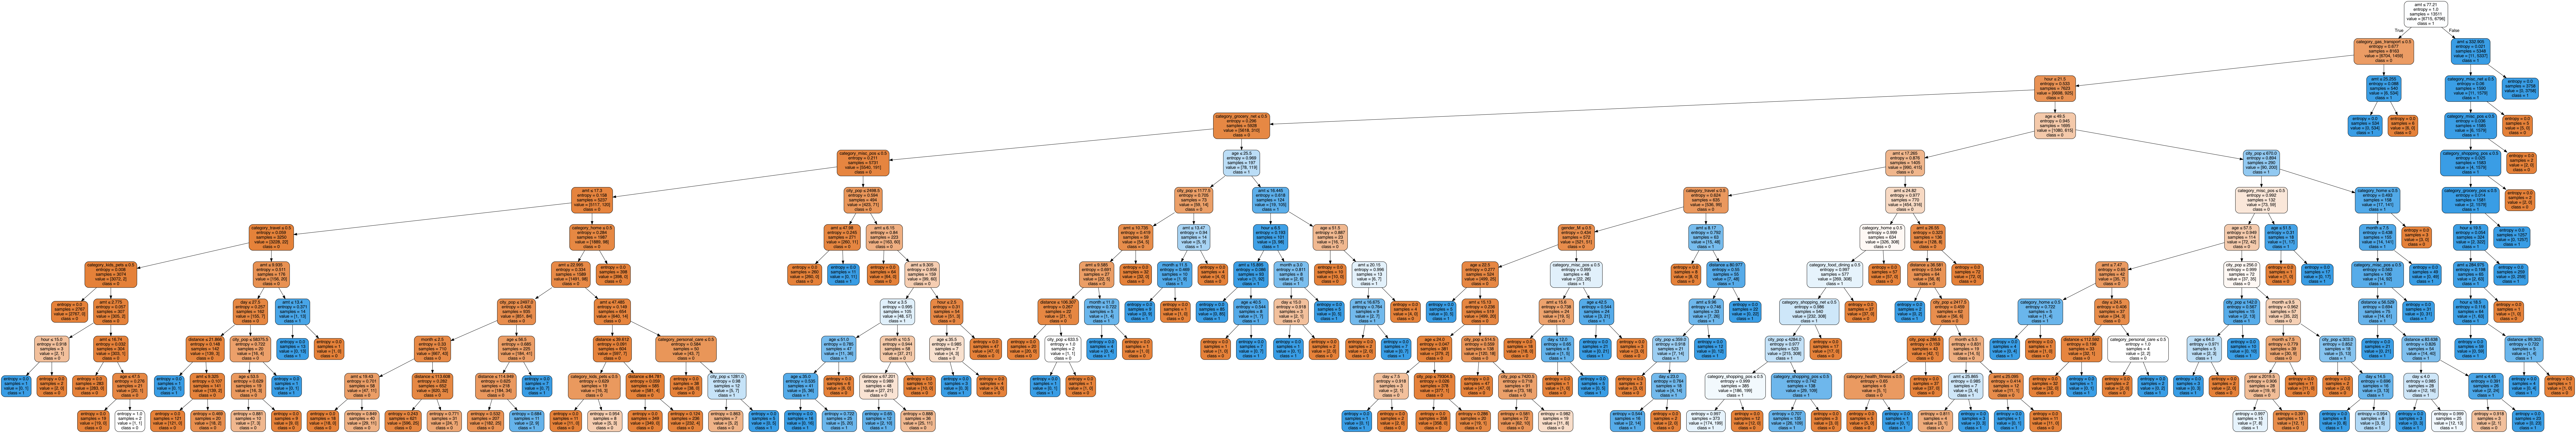

In [83]:
from sklearn.tree import export_graphviz

dot_data = StringIO()
export_graphviz(
    gcv.best_estimator_, 
    out_file=dot_data,  
    filled=True,
    rounded=True,
    special_characters=True,
    feature_names=X_res.columns,
    class_names=['0','1']
)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# graph.write_png('fraud_decision_tree.png')
Image(graph.create_png())

In [84]:
from sklearn.metrics import classification_report

y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96      2936
           1       0.97      0.96      0.96      2855

    accuracy                           0.96      5791
   macro avg       0.96      0.96      0.96      5791
weighted avg       0.96      0.96      0.96      5791



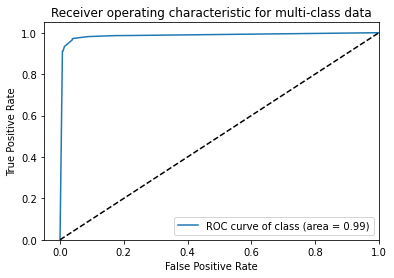

In [94]:
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeClassifier

n_classes = 1

y_score = gcv.best_estimator_.fit(X_train, y_train).predict_proba(X_test)


fpr = []
tpr = []
roc_auc = []
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"ROC curve of class (area = {roc_auc:.2f})")
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

In [39]:
X_train.shape

(13511, 22)

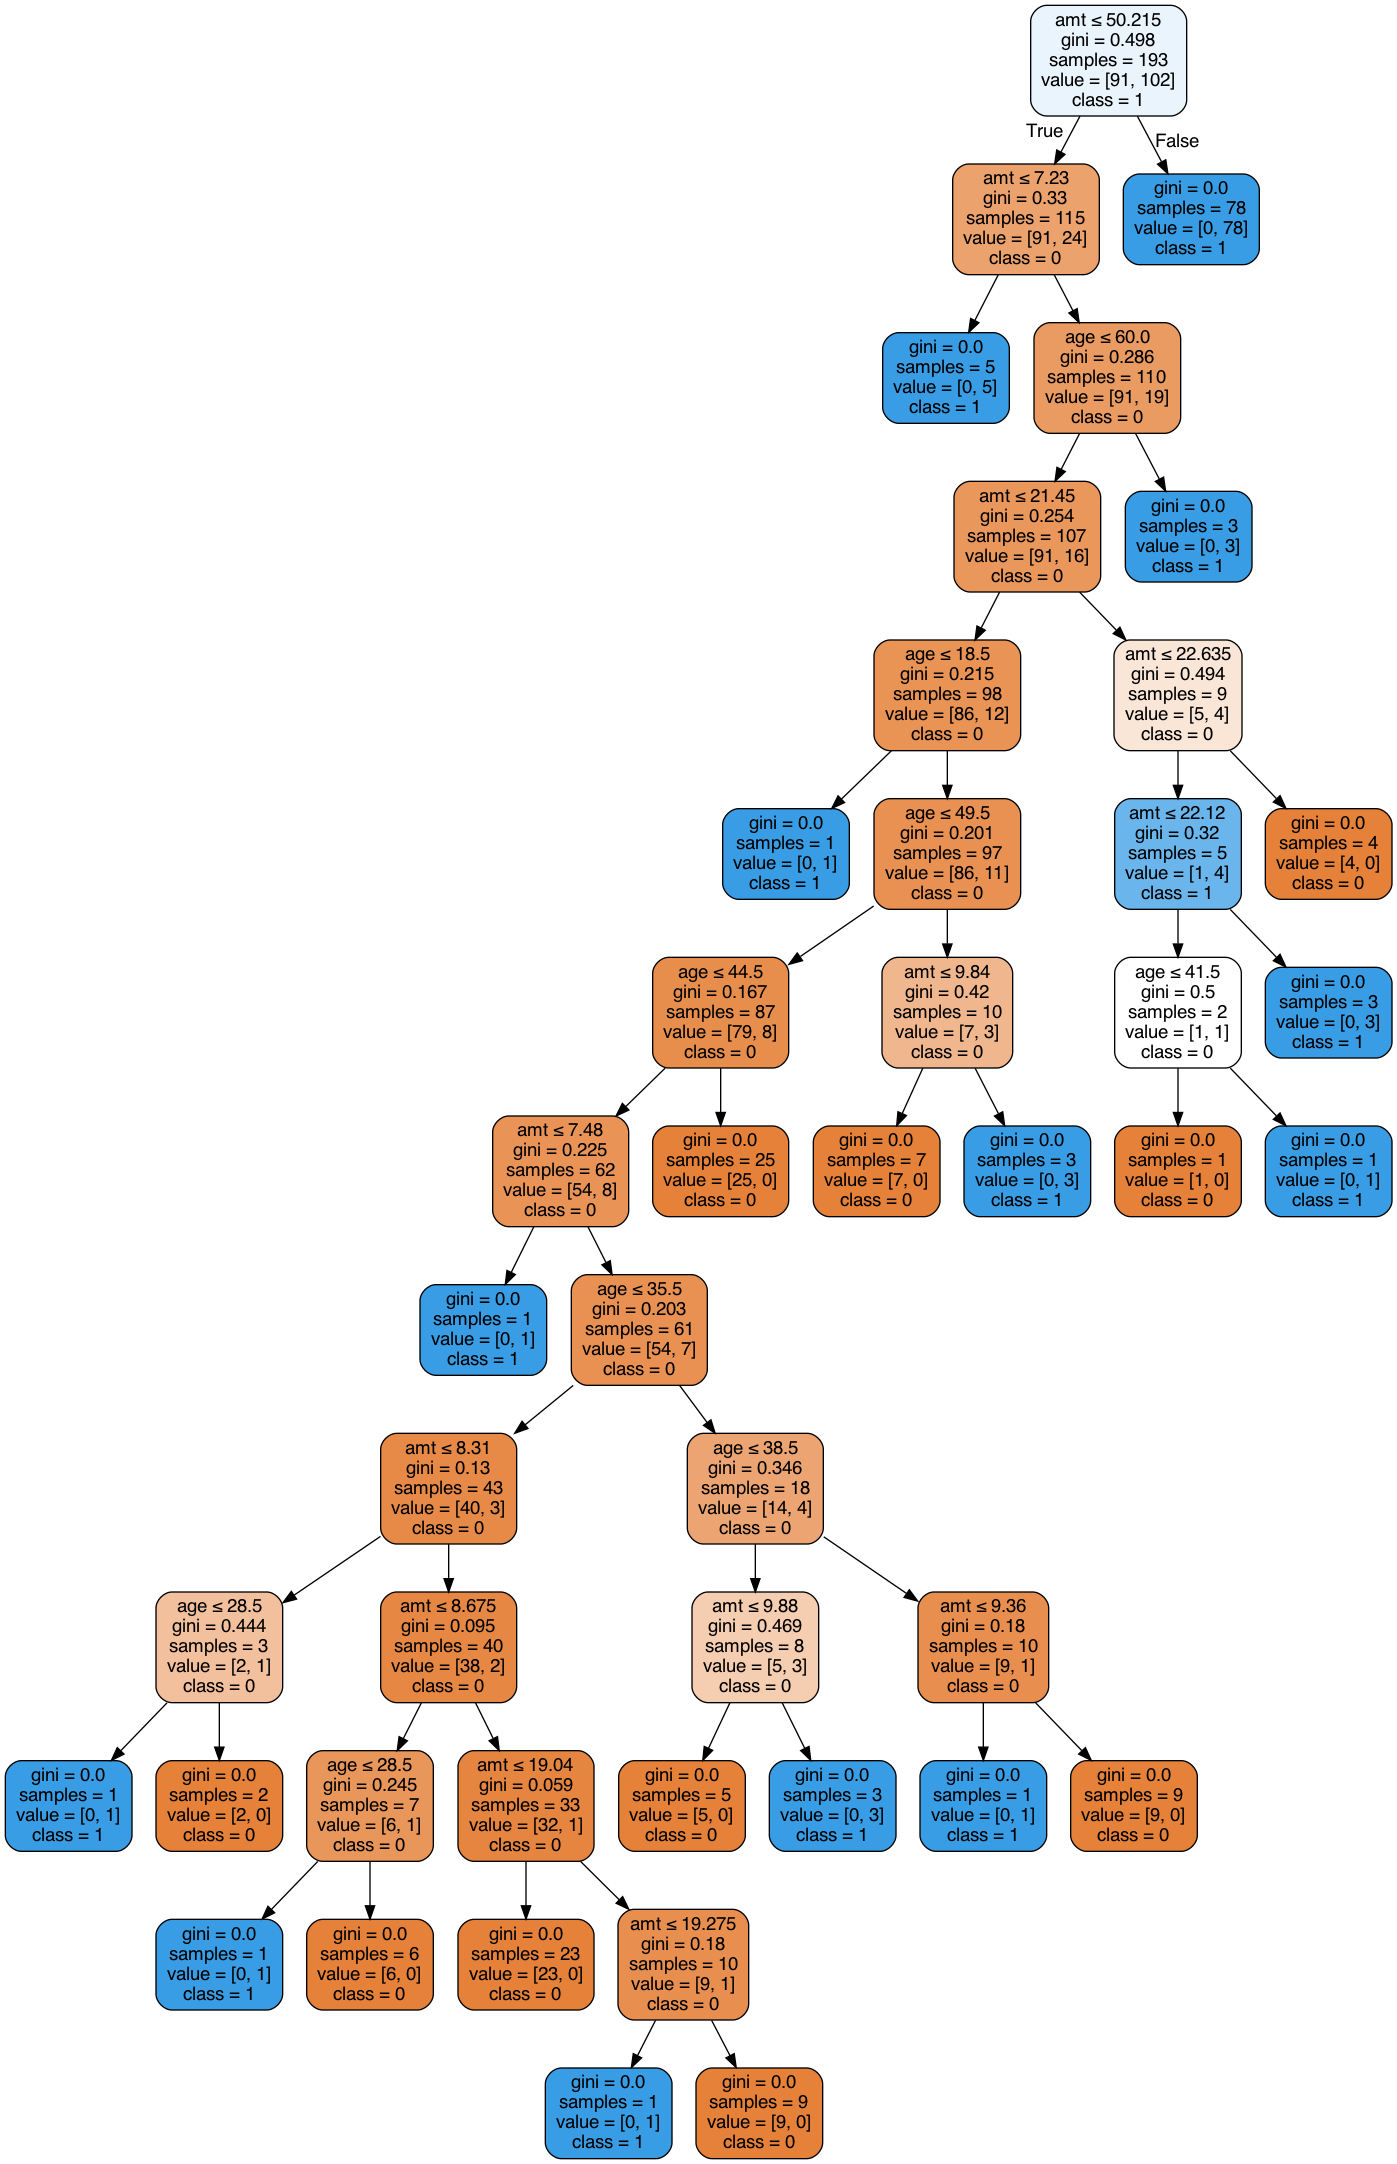

In [18]:
from sklearn.tree import export_graphviz
from six import StringIO  
from IPython.display import Image  
import pydotplus

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# graph.write_png('fraud_decision_tree.png')
Image(graph.create_png())

In [5]:
# Grid search k value for SMOTE oversampling for imbalanced classification
# Define dataset
x_train, y_train = make_classificimport pandas as pd
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculationation(n_samples=12000, n_features=2, n_redundant=0, n_clusters_per_class=1, 
                           weights=[0.99], flip_y=0, random_state=1)

k_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
for k in k_values:
# Define pipeline
    model = DecisionTreeClassifier()
    over = SMOTE(sampling_strategy=0.2, k_neighbors=k)
    under = RandomUnderSampler(sampling_strategy=0.5)
    steps = [('over', over), ('under', under), ('model', model)]
    pipeline = Pipeline(steps=steps)
    
# Evaluate pipeline
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(pipeline, x_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
    print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.752
Mean ROC AUC: 0.780
Mean ROC AUC: 0.790
Mean ROC AUC: 0.800
Mean ROC AUC: 0.819
Mean ROC AUC: 0.813
Mean ROC AUC: 0.822
Mean ROC AUC: 0.839
Mean ROC AUC: 0.830
Mean ROC AUC: 0.860


In [58]:
from sklearn import datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.tree import DecisionTreeClassifier
from scipy import interp


iris = datasets.load_iris()
X = iris.data
y = iris.target

y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=0)

classifier = DecisionTreeClassifier()

y_score = classifier.fit(X_train, y_train).predict(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

#ROC curve for a specific class here for the class 2
roc_auc[2]

0.9485294117647057